In [2]:
!pip install torchsummary

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computations
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [4]:
%matplotlib inline

In [5]:
data_dir = "../input/plantdoc6721"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [6]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Corn leaf blight', 'Tomato leaf', 'Tomato leaf mosaic virus', 'Squash Powdery mildew leaf', 'Potato leaf late blight', 'Soyabean leaf', 'Peach leaf', 'Tomato leaf late blight', 'Apple leaf', 'Tomato mold leaf', 'Corn Gray leaf spot', 'Tomato leaf yellow virus', 'Strawberry leaf', 'Cherry leaf', 'Apple rust leaf', 'Potato leaf early blight', 'grape leaf black rot', 'Apple Scab Leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Blueberry leaf', 'Bell_pepper leaf spot', 'Corn rust leaf', 'Bell_pepper leaf', 'grape leaf', 'Tomato Early blight leaf', 'Raspberry leaf']
Total disease classes are: 27


In [7]:
plants = []
for plant in diseases:
    if plant.split(' ')[0] not in plants:
        plants.append(plant.split(' ')[0])

In [8]:
# Unique plants in the dataset
print("Number of Classes: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
    print(str(idx + 1) + '. ' + plant)


Number of Classes: 13
Unique Plants are: 
1. Corn
2. Tomato
3. Squash
4. Potato
5. Soyabean
6. Peach
7. Apple
8. Strawberry
9. Cherry
10. grape
11. Blueberry
12. Bell_pepper
13. Raspberry


In [9]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Corn leaf blight,187
Tomato leaf,186
Tomato leaf mosaic virus,188
Squash Powdery mildew leaf,187
Potato leaf late blight,188
Soyabean leaf,185
Peach leaf,186
Tomato leaf late blight,185
Apple leaf,187
Tomato mold leaf,186


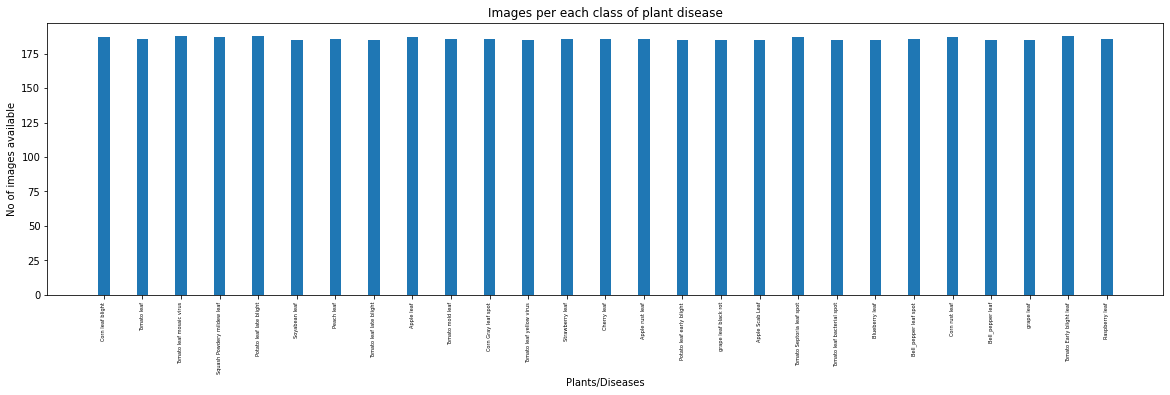

In [10]:
# plotting number of images available for each disease
index = [n for n in range(len(disease_class_size.values()))]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')
plt.savefig('/kaggle/working/ClassDistribution_PlantDoc_AfterOfflineAugmentation')

In [11]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.27129, 0.28836, 0.26273], std=[0.09086, 0.12649, 0.08288]),
            transforms.Resize((224, 224))
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [12]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [13]:
len(train_dataset.dataset.imgs)

5023

In [14]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 5


In [15]:
print(f"There are {len(train_dataset) + len(validation_dataset) + len(test_dataset)} images in total")

print(f"There are {len(train_dataset)} images for training")

print(f"There are {len(validation_dataset)} images for validation")

print(f"There are {len(test_dataset)} images for testing")

There are 5023 images in total
There are 3517 images for training
There are 502 images for validation
There are 1004 images for testing


In [16]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

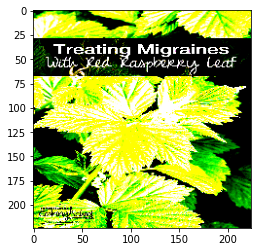

In [17]:
show_image(*train_dataset[21])

In [18]:
# Setting the seed value
random_seed = 7
a = torch.manual_seed(random_seed)

In [19]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [20]:
len(train_dataset)

3517

In [21]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

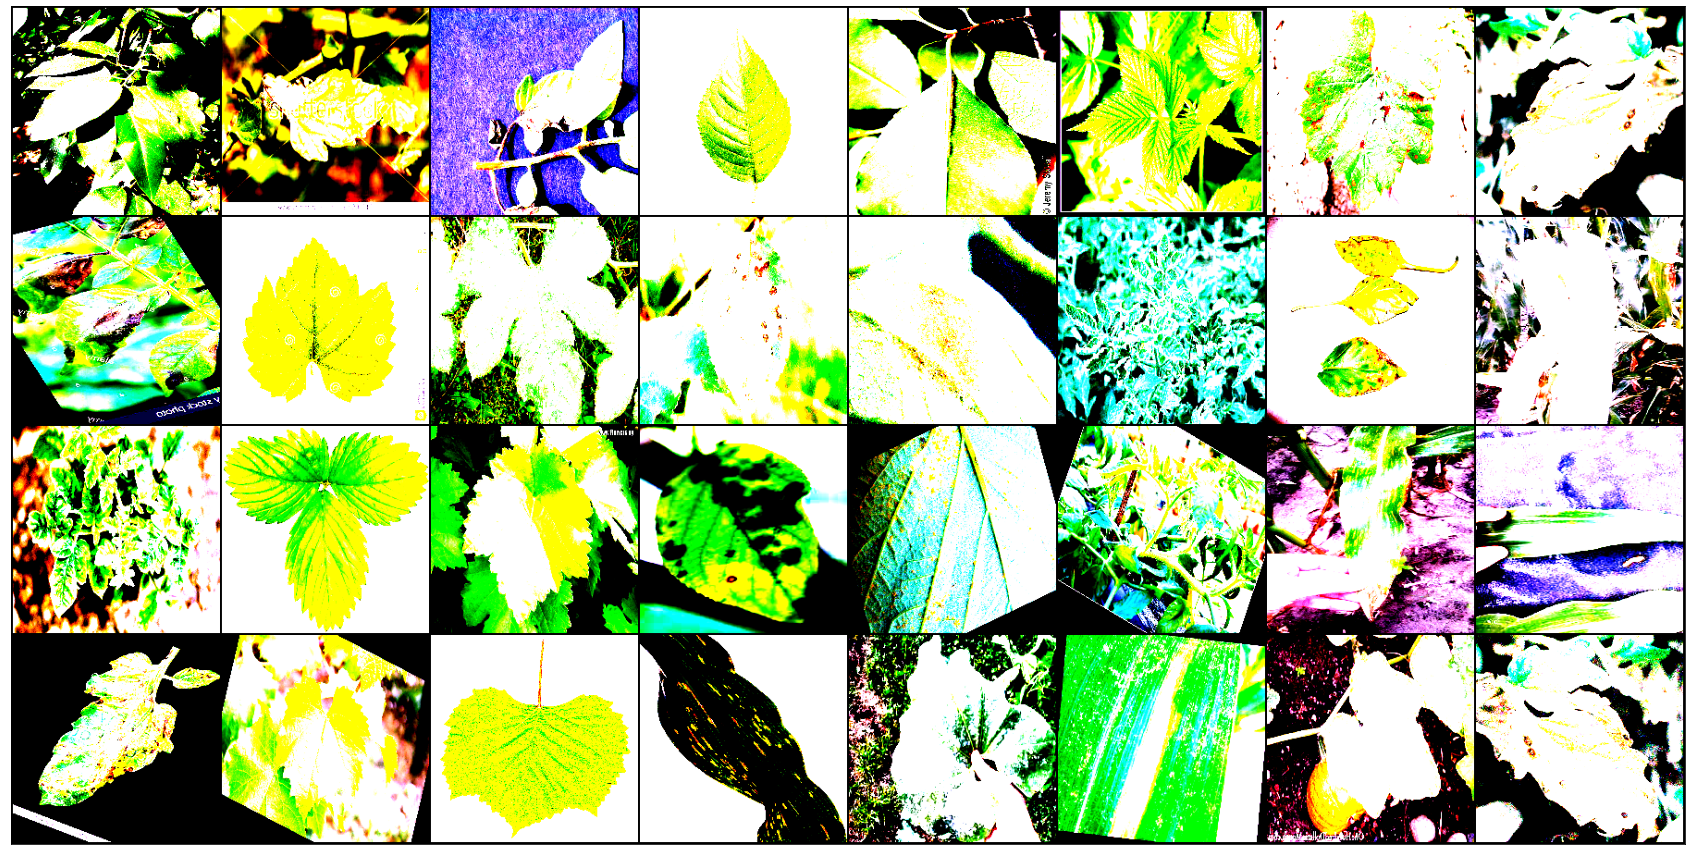

In [22]:
show_batch(train_dataloader)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

cuda:0


In [24]:
# Moving data into GPU
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)

In [25]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [26]:
# defining the model and moving it to the GPU

model_vgg16 = models.vgg16(pretrained=False)
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=len(train_dataset.dataset.classes))
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=0.001)

In [29]:
loss_fn = nn.CrossEntropyLoss()

In [30]:
len(train_dataloader)

110

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_vgg16.to(device)

accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []

num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model_vgg16(images)
        loss = loss_fn(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_vgg16.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_vgg16(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = loss_fn(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/40], Step [10/110], Loss: 3.2968, Accuracy: 3.12%
Epoch [1/40], Loss: 3.2904, Validation Accuracy: 3.98%
Epoch [1/40], Step [20/110], Loss: 3.2983, Accuracy: 6.25%
Epoch [1/40], Loss: 3.2887, Validation Accuracy: 5.38%
Epoch [1/40], Step [30/110], Loss: 3.2989, Accuracy: 0.00%
Epoch [1/40], Loss: 3.2954, Validation Accuracy: 3.59%
Epoch [1/40], Step [40/110], Loss: 3.2971, Accuracy: 9.38%
Epoch [1/40], Loss: 3.2970, Validation Accuracy: 3.78%
Epoch [1/40], Step [50/110], Loss: 3.4310, Accuracy: 3.12%
Epoch [1/40], Loss: 3.2935, Validation Accuracy: 3.78%
Epoch [1/40], Step [60/110], Loss: 3.2949, Accuracy: 0.00%
Epoch [1/40], Loss: 3.2960, Validation Accuracy: 3.78%
Epoch [1/40], Step [70/110], Loss: 3.2986, Accuracy: 3.12%
Epoch [1/40], Loss: 3.2966, Validation Accuracy: 3.78%
Epoch [1/40], Step [80/110], Loss: 3.2957, Accuracy: 3.12%
Epoch [1/40], Loss: 3.2987, Validation Accuracy: 3.78%
Epoch [1/40], Step [90/110], Loss: 3.2946, Accuracy: 6.25%
Epoch [1/40], 

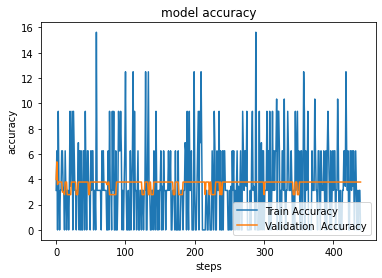

In [32]:
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation  Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_PlantDoc-VGG16')
plt.show()

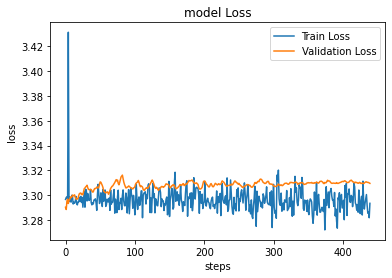

In [33]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Loss_Plot_PlantDoc-VGG16')
plt.show()

In [34]:
torch.save(model_vgg16, '/kaggle/working/Model_PlantDoc-VGG16.pth')
# model = torch.load('model.pth')

In [35]:
model_vgg16.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_vgg16(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 3.78%


In [36]:
y_pred = []
y_true = []
features_tsne = None

model_vgg16.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_vgg16(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()
        
        prediction_result = test_prediction.data.cpu().numpy()
        gt_label = test_labels.data.cpu().numpy()
        
        y_pred.extend(prediction_result) # Save Prediction
        y_true.extend(gt_label) # Save Truth
        
        # For t-SNE
        curr_f = predicted_outputs.cpu().numpy()
        if features_tsne is not None:
            features_tsne = np.concatenate((features_tsne, curr_f))
        else:
            features_tsne = curr_f
        
    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 2.59%


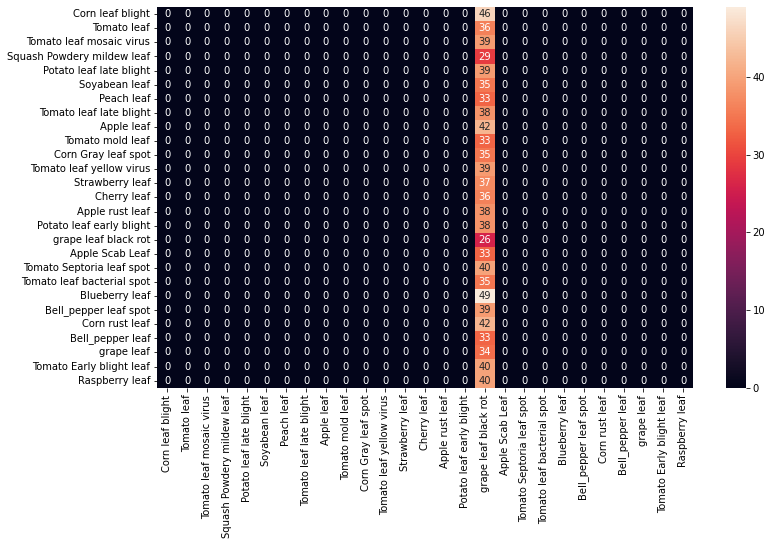

In [37]:
confusion_matrix_vec = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(confusion_matrix_vec,
                     index = [i for i in diseases],
                     columns = [i for i in diseases])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/Confusion_Matrix_PlantDoc-VGG16.png')

In [38]:
# (True Positive + True Negative) / Total Predictions
accuracy = accuracy_score(y_true, y_pred)

# True Positive / (True Positive + False Positive)
precision = precision_score(y_true, y_pred, average='weighted')

# True Positive / (True Positive + False Negative)
sensitivity_recall = recall_score(y_true, y_pred, average='weighted')

# True Negative / (True Negative + False Positive)
specificity = recall_score(y_true, y_pred, average='weighted')

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
f1_score = f1_score(y_true, y_pred, average='weighted')
      
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Sensitivity_recall: {:.2f}%".format(sensitivity_recall*100))
print("Specificity: {:.2f}%".format(specificity*100))
print("F1 Score: {:.2f}%".format(f1_score*100))

Accuracy: 2.59%
Precision: 0.07%
Sensitivity_recall: 2.59%
Specificity: 2.59%
F1 Score: 0.13%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
## TSNE ##

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate= 'auto', init='random').fit_transform(features_tsne)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def visualize_both_tsne_points(diseases, tx1, ty1, labels1, tx2, ty2, labels2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
    
    for disease_index in range(len(diseases)):
        ax1.title.set_text(title1)
        indices = [i for i, l in enumerate(labels1) if l == disease_index]
        current_tx = np.take(tx1, indices)
        current_ty = np.take(ty1, indices)
        ax1.scatter(current_tx, current_ty, label=diseases[disease_index])

    for disease_index in range(len(diseases)):
        ax2.title.set_text(title2)
        indices = [i for i, l in enumerate(labels2) if l == disease_index]
        current_tx = np.take(tx2, indices)
        current_ty = np.take(ty2, indices)
        ax2.scatter(current_tx, current_ty, label=diseases[disease_index])
    
    ax2.legend(bbox_to_anchor=(1, 1.01))
    plt.savefig('/kaggle/working/TNSE_Plot_PlantDoc-VGG16')
    plt.show()

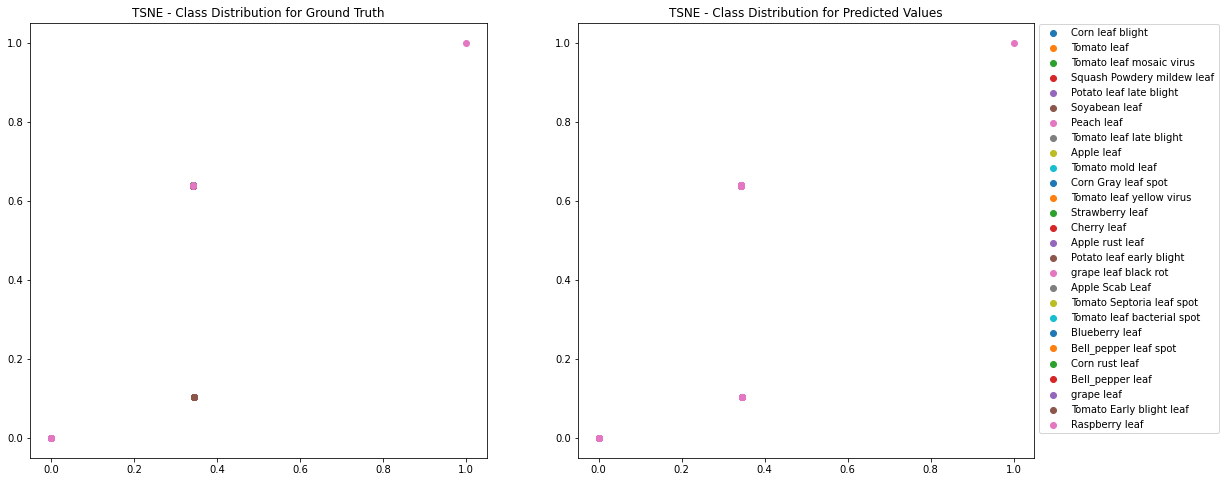

In [40]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_gt = tsne[:, 0]
ty_gt = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_gt = scale_to_01_range(tx_gt)
ty_gt = scale_to_01_range(ty_gt)


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_pred = tsne[:, 0]
ty_pred = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_pred = scale_to_01_range(tx_pred)
ty_pred = scale_to_01_range(ty_pred)


# visualize the plot
visualize_both_tsne_points(diseases, tx_gt, ty_gt, y_true, tx_pred, ty_pred, y_pred, 'TSNE - Class Distribution for Ground Truth', 'TSNE - Class Distribution for Predicted Values')

In [41]:
str(accuracy_train)

'[3.125, 6.25, 0.0, 9.375, 3.125, 0.0, 3.125, 3.125, 6.25, 6.25, 3.4482758620689653, 3.125, 0.0, 6.25, 3.125, 0.0, 3.125, 3.125, 0.0, 3.125, 9.375, 3.4482758620689653, 6.25, 9.375, 0.0, 9.375, 6.25, 3.125, 3.125, 0.0, 3.125, 3.125, 6.896551724137931, 0.0, 6.25, 0.0, 6.25, 0.0, 0.0, 6.25, 6.25, 0.0, 9.375, 3.4482758620689653, 0.0, 6.25, 6.25, 3.125, 3.125, 0.0, 6.25, 3.125, 6.25, 6.25, 0.0, 3.125, 3.125, 0.0, 15.625, 3.125, 3.125, 3.125, 3.125, 3.125, 3.125, 0.0, 6.25, 3.125, 6.25, 3.125, 3.125, 3.125, 3.125, 0.0, 0.0, 6.25, 0.0, 9.375, 3.125, 3.125, 0.0, 9.375, 3.125, 9.375, 0.0, 0.0, 6.25, 0.0, 0.0, 3.125, 9.375, 6.25, 6.25, 9.375, 6.25, 0.0, 3.125, 0.0, 3.4482758620689653, 6.25, 12.5, 3.125, 0.0, 0.0, 3.125, 0.0, 0.0, 6.25, 0.0, 3.4482758620689653, 6.25, 12.5, 0.0, 9.375, 3.125, 3.125, 0.0, 3.125, 6.25, 0.0, 0.0, 3.125, 3.125, 0.0, 3.125, 3.125, 0.0, 3.125, 3.125, 12.5, 0.0, 0.0, 6.25, 12.5, 3.125, 3.125, 0.0, 0.0, 3.125, 3.125, 0.0, 6.25, 3.4482758620689653, 0.0, 9.375, 3.125, 0.0, 

In [42]:
str(accuracy_validation)

'[3.9840637450199203, 5.378486055776892, 3.5856573705179287, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 2.9880478087649402, 2.9880478087649402, 2.9880478087649402, 2.788844621513944, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 2.788844621513944, 2.788844621513944, 2.788844621513944, 2.788844621513944, 2.788844621513944, 2.788844621513944, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 2.788844621513944, 2.788844621513944, 2.788844621513944, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 3.7848605577689245, 2.788844621513944, 2.788844621513944, 3.7848605577689245, 3.784860557

In [43]:
str(loss_train)

'[3.2967889308929443, 3.2982964515686035, 3.298877000808716, 3.2970566749572754, 3.4310078620910645, 3.294938325881958, 3.2985613346099854, 3.2957053184509277, 3.294571876525879, 3.3000564575195312, 3.2993929386138916, 3.2930941581726074, 3.294501781463623, 3.293735980987549, 3.295219898223877, 3.2991702556610107, 3.293456554412842, 3.2923901081085205, 3.29476261138916, 3.2947444915771484, 3.298473596572876, 3.295370101928711, 3.299198627471924, 3.2943127155303955, 3.2983760833740234, 3.2905361652374268, 3.2967796325683594, 3.3033547401428223, 3.290539026260376, 3.3049228191375732, 3.3039355278015137, 3.29549241065979, 3.3015358448028564, 3.2968862056732178, 3.2958974838256836, 3.29695725440979, 3.30458927154541, 3.2942159175872803, 3.2923903465270996, 3.293955087661743, 3.293095827102661, 3.296309471130371, 3.296473979949951, 3.2972490787506104, 3.2942442893981934, 3.287970781326294, 3.3002731800079346, 3.308915138244629, 3.3007025718688965, 3.2934980392456055, 3.295498847961426, 3.30

In [44]:
str(loss_validation)

'[3.290423631668091, 3.288672685623169, 3.2953720092773438, 3.297046661376953, 3.2934958934783936, 3.296027183532715, 3.296609401702881, 3.2987029552459717, 3.298200845718384, 3.2987022399902344, 3.3002710342407227, 3.29972243309021, 3.2997617721557617, 3.3004515171051025, 3.2985010147094727, 3.297001838684082, 3.2975997924804688, 3.2970387935638428, 3.2974700927734375, 3.299917459487915, 3.301433563232422, 3.301727294921875, 3.30191969871521, 3.3006463050842285, 3.300859212875366, 3.300549268722534, 3.3028719425201416, 3.305433511734009, 3.3059449195861816, 3.3068039417266846, 3.3073248863220215, 3.30814528465271, 3.306225061416626, 3.3047966957092285, 3.3045966625213623, 3.304581642150879, 3.3049330711364746, 3.3046035766601562, 3.3035929203033447, 3.302670478820801, 3.3027899265289307, 3.3045027256011963, 3.305513620376587, 3.305488348007202, 3.3056833744049072, 3.3066718578338623, 3.306570291519165, 3.3058836460113525, 3.306535243988037, 3.30902099609375, 3.3108413219451904, 3.3105

In [45]:
str(y_pred)

'[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

In [46]:
str(y_true)

'[23, 15, 4, 19, 12, 7, 5, 26, 13, 5, 25, 18, 7, 11, 1, 8, 11, 21, 9, 10, 12, 6, 10, 20, 6, 24, 8, 15, 17, 22, 25, 16, 1, 0, 15, 14, 2, 13, 23, 20, 25, 8, 8, 23, 22, 12, 18, 17, 25, 2, 4, 6, 15, 10, 6, 20, 10, 4, 21, 7, 20, 24, 4, 4, 17, 25, 25, 7, 17, 18, 6, 16, 21, 8, 16, 2, 12, 4, 0, 19, 10, 1, 22, 21, 4, 22, 19, 19, 18, 22, 18, 0, 20, 1, 12, 17, 25, 8, 13, 12, 23, 8, 7, 5, 17, 20, 19, 11, 10, 18, 26, 13, 5, 24, 26, 6, 18, 6, 12, 0, 2, 22, 2, 5, 11, 24, 15, 20, 22, 18, 19, 1, 2, 13, 8, 20, 13, 26, 19, 7, 3, 10, 8, 17, 0, 19, 25, 24, 26, 0, 7, 1, 0, 21, 12, 2, 10, 0, 14, 25, 23, 5, 23, 26, 12, 21, 5, 0, 11, 8, 20, 10, 14, 20, 20, 26, 12, 11, 1, 25, 6, 11, 13, 8, 7, 22, 23, 4, 9, 15, 6, 7, 14, 24, 13, 7, 25, 6, 19, 20, 19, 25, 8, 18, 5, 18, 26, 12, 6, 11, 2, 24, 18, 5, 16, 11, 14, 19, 9, 21, 6, 2, 26, 14, 24, 23, 0, 0, 15, 26, 23, 17, 22, 13, 15, 17, 21, 25, 0, 10, 13, 4, 26, 22, 24, 7, 26, 7, 23, 20, 2, 1, 1, 3, 4, 12, 14, 4, 3, 4, 11, 5, 9, 7, 1, 10, 4, 25, 22, 15, 3, 10, 12, 18, 20